Integrantes: 

- José Villar
- Pablo Oñate
- Catalina Montecinos



---



# **Importar librerias necesarias**

In [83]:
# Para la Data
import pandas as pd
import numpy as np

# Para la Visualización
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import missingno as msno
from wordcloud import WordCloud
import re 
import string
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from PIL import Image

# Para NLP
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')

# Para Styling
plt.style.use('fivethirtyeight')

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




---


# **Lectura del dataset y su distribución**


Lectura del *Train*

In [84]:
df = pd.read_csv('./Corona_NLP_train.csv',encoding='latin-1')
test = pd.read_csv('./Corona_NLP_test.csv',encoding="latin-1")
df['TweetAt'] = pd.to_datetime(df['TweetAt'])
df['Length'] = df['OriginalTweet'].apply(len)
train = df
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Length
0,3799,48751,London,2020-03-16,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,111
1,3800,48752,UK,2020-03-16,advice Talk to your neighbours family to excha...,Positive,237
2,3801,48753,Vagabonds,2020-03-16,Coronavirus Australia: Woolworths to give elde...,Positive,131
3,3802,48754,NaN,2020-03-16,My food stock is not the only one which is emp...,Positive,306
4,3803,48755,NaN,2020-03-16,"Me, ready to go at supermarket during the #COV...",Extremely Negative,310


Lectura del Test

In [85]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Distribución de los datos

In [86]:
print(train.info(),'\n')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   UserName       41157 non-null  int64         
 1   ScreenName     41157 non-null  int64         
 2   Location       32567 non-null  object        
 3   TweetAt        41157 non-null  datetime64[ns]
 4   OriginalTweet  41157 non-null  object        
 5   Sentiment      41157 non-null  object        
 6   Length         41157 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.2+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   

Se muestran los valores faltantes por cada columna

Text(0.5, 1.0, 'Valores faltantes de cada columna')

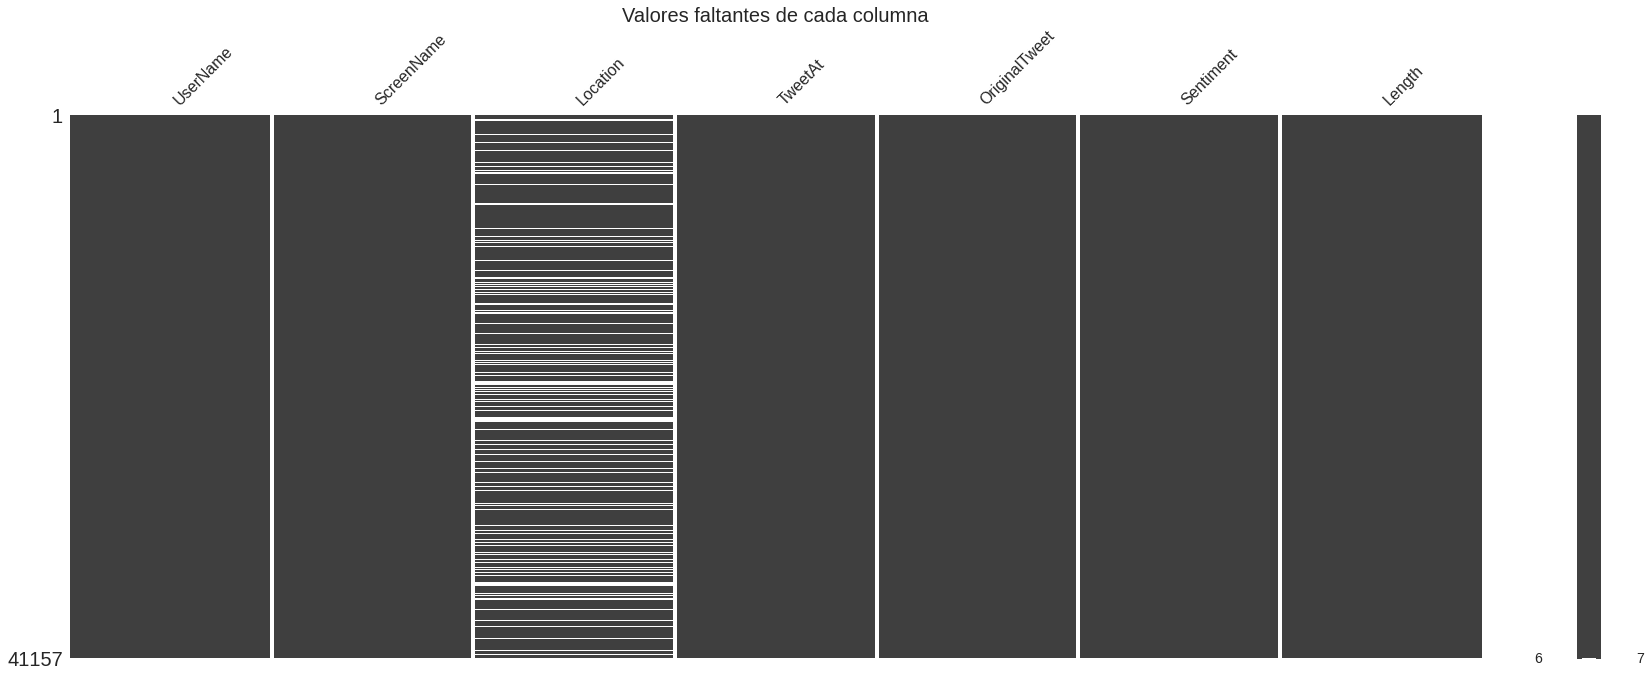

In [87]:
msno.matrix(df)
plt.title('Valores faltantes de cada columna',fontsize=20)

Ahora vamos a eliminar las entradas duplicadas.

In [88]:
train.drop_duplicates(inplace=True)
test.drop_duplicates(inplace=True)

Ahora vamos a eliminar las columnas UserName y ScreenName porque son para una identidad única y no afectarán nuestro modelo.

In [89]:
train.drop(['UserName', 'ScreenName'], axis=1, inplace=True)
test.drop(['UserName', 'ScreenName'], axis=1, inplace=True)

Volvemos a mostrar las columnas, para verificar que se borro y observar los valores faltantes.

Text(0.5, 1.0, 'Valores faltantes de cada columna')

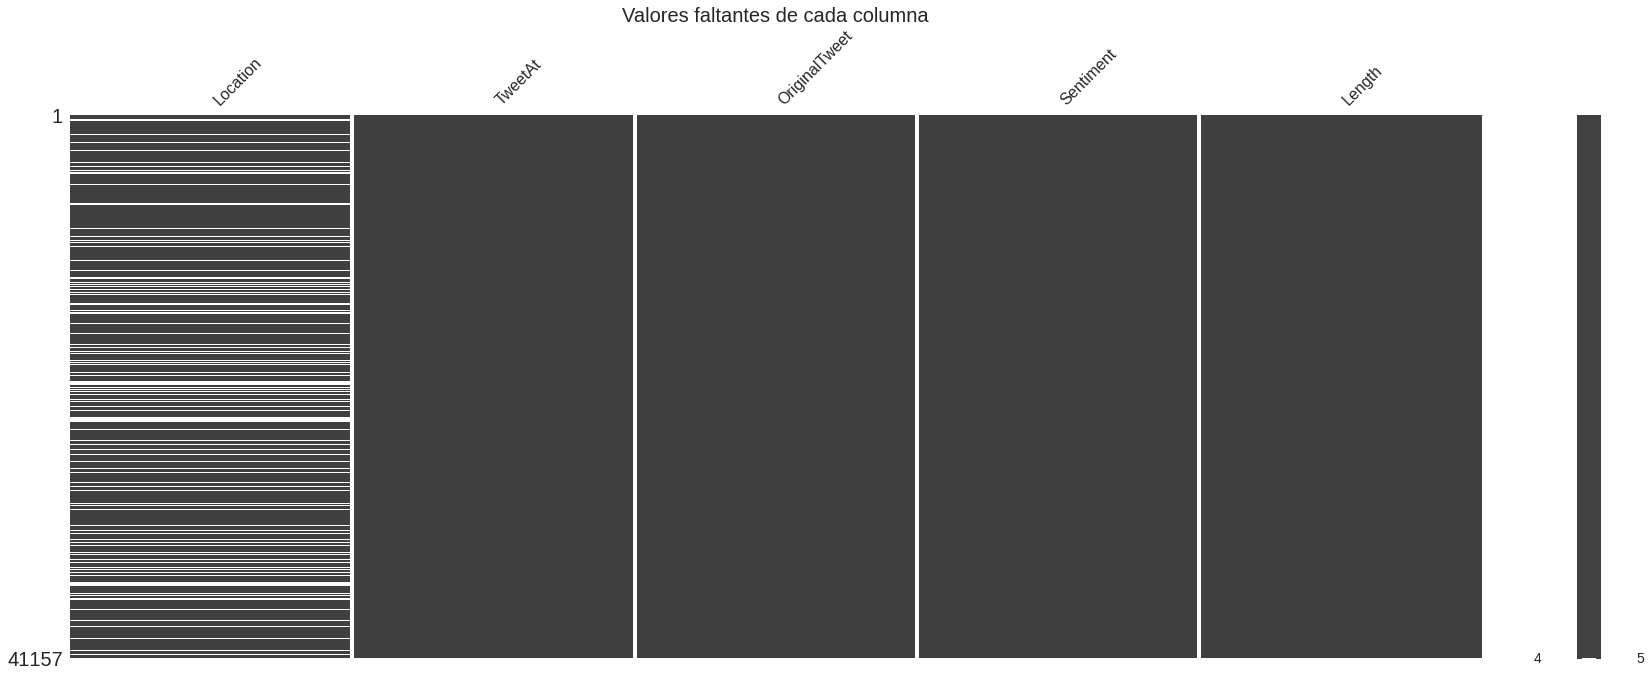

In [90]:
# Nuevamente mostramos las columnas con valores faltantes.
msno.matrix(train)
plt.title('Valores faltantes de cada columna',fontsize=20)

Comprobamos el número de valores perdidos

In [91]:
print(train.isnull().sum())

Location         8590
TweetAt             0
OriginalTweet       0
Sentiment           0
Length              0
dtype: int64


Comprobamos la columna Location

In [92]:
print(train.Location.value_counts(normalize= True, dropna= False)[:30] *100)

NaN                        20.871298
London                      1.312049
United States               1.282892
London, England             1.263455
New York, NY                0.959740
Washington, DC              0.906286
United Kingdom              0.818816
Los Angeles, CA             0.682751
India                       0.651165
UK                          0.563695
Australia                   0.546687
USA                         0.541828
Canada                      0.464077
England, United Kingdom     0.464077
Toronto, Ontario            0.388755
Global                      0.386326
Chicago, IL                 0.376607
California, USA             0.371747
San Francisco, CA           0.369317
Boston, MA                  0.364458
New York, USA               0.340161
New Delhi, India            0.335301
Atlanta, GA                 0.306145
New York                    0.306145
Mumbai, India               0.264840
Worldwide                   0.245402
Lagos, Nigeria              0.240542
H



---


# **Análisis de las columnas del dataset por separado**

## *Columna TweetAt*

TweetAt representa la hora a la que se tuiteó.

Primero, veamos la distribución mensual de tweets:

Text(0.5, 1.0, 'Distribución mensual de tweets')

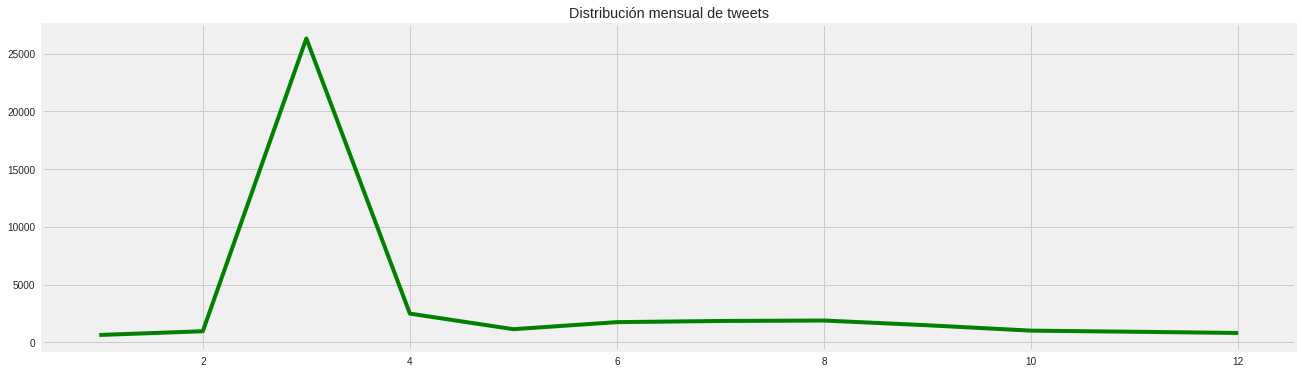

In [93]:
time = df.groupby(['TweetAt']).size()
monthly = df['TweetAt'].dt.month.value_counts().sort_index()
plt.figure(figsize=(20,6))
sns.lineplot(x=monthly.index, y = monthly.values, color='green')
plt.title('Distribución mensual de tweets')

Podemos notar que la fecha del conjunto de datos se distribuye principalmente en marzo;
Y debajo está la distribución de las fechas.

In [94]:
fig = px.line(df, x=time.index, y=time.values, title = 'Fecha de los tweets')
fig.show()

## **Columna Location**


Aquí exploraremos las 10 ubicaciones principales de tweets

In [95]:
location = df['Location'].value_counts()[:10]
fig = px.bar(x=location.index,y=location.values,text=location.values,
       color = location.index, color_discrete_sequence=px.colors.sequential.deep,
        title = 'Distribución del Top 10 de Localizaciones')
us,uk = [1,3,4,6],[0,2,5,8]

for idx in us:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "crimson"
for idx in uk:
    fig.data[idx].marker.line.width = 4
    fig.data[idx].marker.line.color = "blue"
fig.show()

Podemos notar que el Reino Unido y los EE. UU. ocuparon los 2 primeros lugares de tweets de covid-19, y la India y Australia ocuparon el siguiente lugar.

## **Columna Sentiment**


Se observa la cantidad de datos por cada valor y su porcentaje.

In [96]:
print(train.Sentiment.value_counts(),'\n')
print(train.Sentiment.value_counts(normalize=True) * 100)

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64 

Positive              27.752266
Negative              24.095537
Neutral               18.740433
Extremely Positive    16.094468
Extremely Negative    13.317297
Name: Sentiment, dtype: float64



Se genera un grafico de pai para visualizar la distribución de los datos.



In [97]:
sentiment = df["Sentiment"].value_counts()
fig = px.pie(values=sentiment.values, 
             names=sentiment.index,
             color_discrete_sequence=px.colors.sequential.Greens)
fig.update_traces(textposition='inside',
                  textfont_size=11,
                  textinfo='percent+label')
fig.update_layout(title_text="Categoria grafico de Pie",
                  uniformtext_minsize=12, 
                  uniformtext_mode='hide')

fig.show()

Hay 5 sentimientos en el conjunto de datos: Positivo, Negativo, Neutral, Extremadamente Positivo y Extremadamente Negativo.
Cada Positivo y Negativo representan el 27,8% y el 24,1%

Se Compara la longitud del tweet de cada sentimiento.

In [98]:
positive = df.loc[np.where(df['Sentiment'] == 'Positive')].reset_index()
negative = df.loc[np.where(df['Sentiment'] == 'Negative')].reset_index()
neutral = df.loc[np.where(df['Sentiment'] == 'Neutral')].reset_index()
extremely_positive = df.loc[np.where(df['Sentiment'] == 'Extremely Positive')].reset_index()
extremely_negative = df.loc[np.where(df['Sentiment'] == 'Extremely Negative')].reset_index()
hist_data = [extremely_positive['Length'],positive['Length'],neutral['Length'],
             negative['Length'],extremely_negative['Length']]

group_labels = ['extremely_positive','positive','neutral','negative','extremely_negative']

colors = ['navy', 'blue', 'lightblue','lightsalmon','red']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors = colors)

# Add title
fig.update_layout(title_text='Distribución de longitud de cada sentimiento')
fig.show()

El sentimiento de 'extremadamente negativo' y 'extremadamente positivo' se distribuyó mayoritariamente en gran parte, y negativo y positivo el siguiente.



---


# **Análisis del dataset en correlación de las columnas**

Revisaremos los lugares alrededor del mundo que tuitearon más sobre COVID y el estado de ánimo de estos.

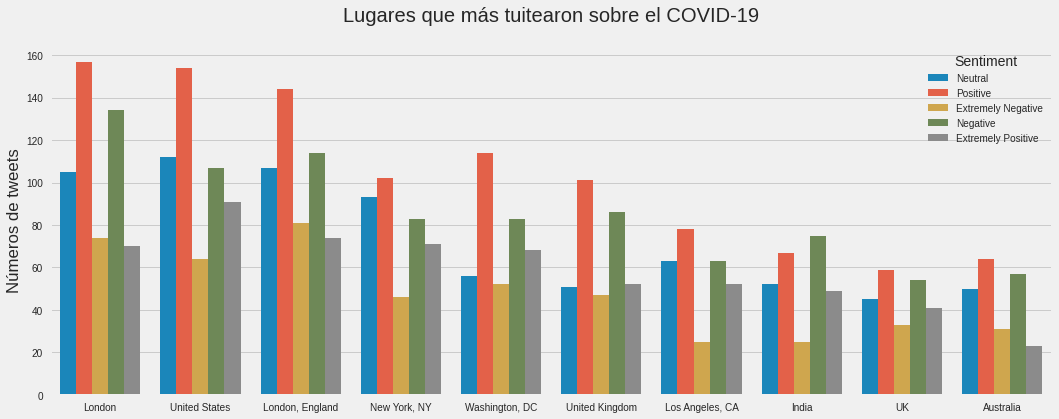

In [100]:
# gráfico de las principales ciudades/países
plt.style.use("fivethirtyeight")

plt.figure(figsize=(16, 6))
location = sns.countplot(x= 'Location', data= train, hue="Sentiment", order=train.Location.value_counts()[:10].index)
location.set_title("Lugares que más tuitearon sobre el COVID-19", y=1.05)

def axis_labels(ax):
    ax.set_ylabel("Números de tweets")
    ax.set_xlabel("")

axis_labels(location)

plt.show()

Londres y Nueva York lideran el camino en términos de ciudades que más tuitearon sobre covid19

También observamos un patrón: hay más tuits positivos que negativos en todas las ciudades/países si combinamos datos de tuits positivos y extremadamente positivos.

TweetAt, que contiene las horas en que se realizaron los tweets, tiene un tipo de datos de objeto; lo convertiremos en un tipo de datos de fecha y hora.

In [101]:
# Convertir la columna TweetAt a fecha y hora 
train['TweetAt'] = pd.to_datetime(train['TweetAt'])

# crear columnas de día de la semana y mes
train['day'] = train['TweetAt'].dt.dayofweek
train['month'] = train['TweetAt'].dt.month

days = {0: 'Monday', 1: 'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
months = {1: 'January ', 2: 'February', 3:'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',
      8:'August', 9:'September', 10: 'October', 11: 'November', 12: 'December'  }

train["day"] = train["day"].map(days)
train["month"] = train["month"].map(months)

In [102]:
print(f"Primer tweet: {train['TweetAt'].dt.date.min()}, Último tweet: {train['TweetAt'].dt.date.max()}")

Primer tweet: 2020-01-04, Último tweet: 2020-12-04


Nuestros datos de tweets, que contienen tweets relacionados con covid realizados solo en 2020, se recopilaron durante un período de 11 meses (del 4 de enero de 2020 al 4 de diciembre de 2020)

Creamos un gráfico que nos muestra el número de tuits realizados según el día de la semana.

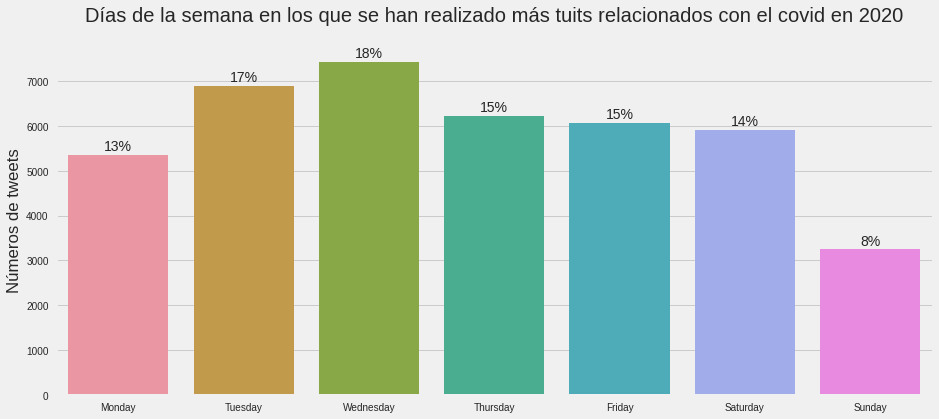

In [103]:
plt.figure(figsize=(14, 6))
days = sns.countplot(x="day", data=train)
days.set_title("Días de la semana en los que se han realizado más tuits relacionados con el covid en 2020", 
                                             y=1.05)

def add_labels(ax, space):
    for rect in ax.patches:
        width = rect.get_width()
        height = rect.get_height()
        total = train.shape[0]
        
        ax.text(rect.get_x() + width/2,
               height + space,
               '{}%'.format(int(np.round(height/total*100))),
                ha="center")

add_labels(days, 100)
axis_labels(days)
plt.show()

Se observa el porcentaje de tuits realizados entre Enero y Diciembre.

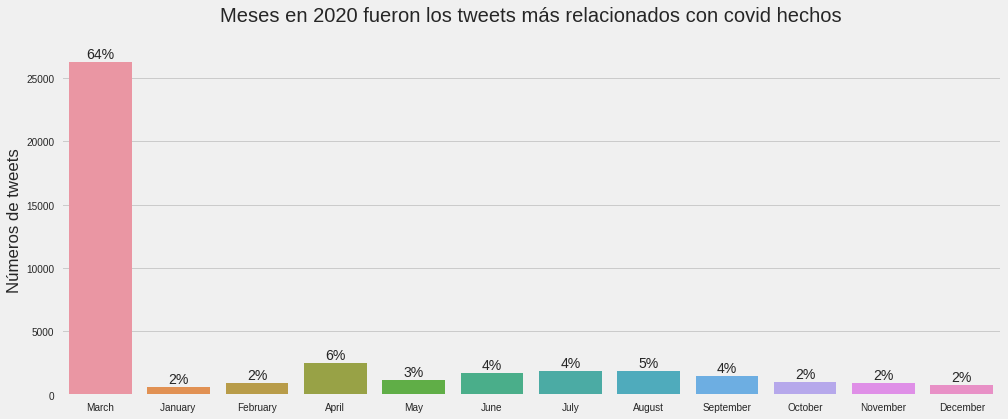

In [104]:
plt.figure(figsize=(15, 6))
months = sns.countplot(train['month'])
months.set_title("Meses en 2020 fueron los tweets más relacionados con covid hechos", 
                                             y=1.05)

add_labels(months, 300)
axis_labels(months)
plt.show()



---


# **Preprocesamiento del texto**

Se imprimen los tuits con el texto original

In [105]:
def tweets(df, n, col_name="OriginalTweet"):
    for tweet_no, tweet in enumerate(df[col_name][:n]):
        print(tweet_no+1, tweet, '\n')
        print("*" * 60, '\n')
        
tweets(train, 10)

1 @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8 

************************************************************ 

2 advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order 

************************************************************ 

3 Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P 

************************************************************ 






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j 

************************************************************ 





#CoronavirusFrance #restezchezvous #StayAtHome #confinement https://t.co/usmuaLq72n 

************************************

Se realiza una limpieza a los textos de los tuits.

In [106]:
# combine train and test dataframes
combined = pd.concat([train, test], ignore_index= True)

# select relevant features: tweet and Sentiments
combined = combined.loc[:, ["OriginalTweet", "Sentiment"]]

# load stop words
stop_word = stopwords.words('english')

def clean_tweet(text):
    text = re.sub(r"#\w+", " ", text)            # remove hashtags
    text = re.sub(r"@\w+", " ",text)             # remove mentions
    text = re.sub(r"http\S+", " ", text)         # remove urls
    text = re.sub(r"[^a-zA-Z]", " ", text)       # remove non-words (digits, punctuations etc)
    text = text.lower().strip()                  # convert tweet to lowercase and strip
    
    text = " ".join([word for word in text.split() if not word in stop_word])           # remove stop words    
    
    text = " ".join(nltk.word_tokenize(text))           # tokenize text
      
    return text

# clean OriginalTweet and assign the data to an new "tweet" column
combined['tweet'] = combined['OriginalTweet'].apply(lambda x: clean_tweet(x))

Se muestran los tuits después del preprocesamiento.

In [107]:
tweets(combined, 8, "tweet")

1  

************************************************************ 

2 advice talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist gp set online shopping accounts poss adequate supplies regular meds order 

************************************************************ 

3 coronavirus australia woolworths give elderly disabled dedicated shopping hours amid covid outbreak 

************************************************************ 

4 food stock one empty please panic enough food everyone take need stay calm stay safe 

************************************************************ 

5 ready go supermarket outbreak paranoid food stock litteraly empty serious thing please panic causes shortage 

************************************************************ 

6 news region first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports 



---


# **Visualización de las palabras**

Visualización de nube de palabras de los hashtags más utilizados

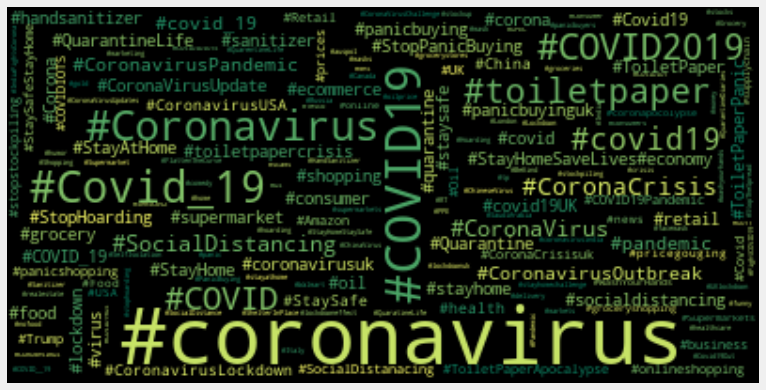

In [111]:
def create_wordCloud(pattern):
    """crear visualización de nube de palabras
    
    argumentos:
        patrón (str): patrón de expresiones regulares para extraer cierto texto de los datos
    """
    data = train["OriginalTweet"].str.extractall(pattern)[0].value_counts()

    data.index = data.index.map(str)                                                       # convertir índice de datos a cadena
    data_wc = WordCloud(max_words = 500, colormap='summer', 
                        background_color='black').generate_from_frequencies(data)          # generar nube de palabras

    
    # mostrar la nube
    fig = plt.figure()
    fig.set_figwidth(12) # establecer ancho
    fig.set_figheight(12) # establecer alto

    plt.imshow(data_wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
# crear una nube de palabras de los hashtags más utilizados
hashtag = r"(#\w+)"
create_wordCloud(hashtag)

Visualización de nube de palabras más utilizados

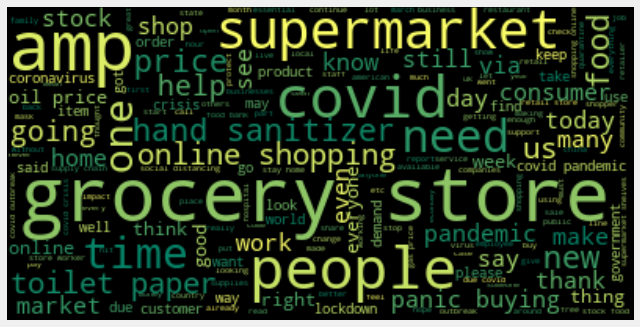

In [112]:
# palabras más comunes en el datataset de tweet
corpus = ",".join(word for word in combined.tweet)
stopwords = set(STOPWORDS)
tweet_wc = WordCloud(max_words = 500, colormap='summer', 
                        background_color='black', stopwords=stopwords).generate(corpus)   

# mostrar la nube
fig = plt.figure()
fig.set_figwidth(10) # establecer ancho
fig.set_figheight(10) # establecer alto

plt.imshow(tweet_wc, interpolation="bilinear")
plt.axis("off")
plt.show()